In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 

In [6]:
# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [7]:
IMAGE_SIZE = 32

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    # cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [5]:
!rm *.hdf5

rm: cannot remove '*.hdf5': No such file or directory


In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

mcp_cb = ModelCheckpoint(filepath='/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)

ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True, validation_data=(val_images, val_oh_labels), callbacks=[mcp_cb, rlr_cb, ely_cb])

2022-09-20 01:55:21.799851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 01:55:21.898447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 01:55:21.899201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 01:55:21.900891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30


2022-09-20 01:55:28.099245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1329/1329 [==============================] - 17s 7ms/step - loss: 1.5650 - accuracy: 0.4311 - val_loss: 1.3917 - val_accuracy: 0.5083
Epoch 2/30
1329/1329 [==============================] - 8s 6ms/step - loss: 1.1019 - accuracy: 0.6090 - val_loss: 0.9483 - val_accuracy: 0.6600
Epoch 3/30
1329/1329 [==============================] - 10s 7ms/step - loss: 0.9127 - accuracy: 0.6821 - val_loss: 0.8899 - val_accuracy: 0.6845
Epoch 4/30
1329/1329 [==============================] - 10s 8ms/step - loss: 0.8074 - accuracy: 0.7201 - val_loss: 0.8182 - val_accuracy: 0.7171
Epoch 5/30
1329/1329 [==============================] - 8s 6ms/step - loss: 0.7254 - accuracy: 0.7502 - val_loss: 0.7783 - val_accuracy: 0.7324
Epoch 6/30
1329/1329 [==============================] - 8s 6ms/step - loss: 0.6498 - accuracy: 0.7779 - val_loss: 1.0198 - val_accuracy: 0.6695
Epoch 7/30
1329/1329 [==============================] - 8s 6ms/step - loss: 0.5955 - accuracy: 0.7970 - val_loss: 0.9186 - val_accuracy: 0.6995


In [7]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.5819 - accuracy: 0.8589


[0.5819385647773743, 0.8589000105857849]

In [10]:
!ls -lia

total 28848
   262147 drwxr-xr-x 3 root root    4096 Sep 20 01:57 .
141082764 drwxr-xr-x 5 root root    4096 Sep 20 01:54 ..
   262152 drwxr-xr-x 2 root root    4096 Sep 20 01:54 .virtual_documents
   262149 ---------- 1 root root     263 Sep 20 01:54 __notebook_source__.ipynb
   262153 -rw-r--r-- 1 root root 3688760 Sep 20 01:55 weights.01-1.39.hdf5
   262154 -rw-r--r-- 1 root root 3688760 Sep 20 01:55 weights.02-0.95.hdf5
   262155 -rw-r--r-- 1 root root 3688760 Sep 20 01:56 weights.03-0.89.hdf5
   262156 -rw-r--r-- 1 root root 3688760 Sep 20 01:56 weights.04-0.82.hdf5
   262157 -rw-r--r-- 1 root root 3688760 Sep 20 01:56 weights.05-0.78.hdf5
   262158 -rw-r--r-- 1 root root 3688760 Sep 20 01:56 weights.08-0.57.hdf5
   262159 -rw-r--r-- 1 root root 3688760 Sep 20 01:57 weights.10-0.55.hdf5
   262160 -rw-r--r-- 1 root root 3688760 Sep 20 01:57 weights.16-0.47.hdf5


In [11]:
model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/kaggle/working/weights.16-0.47.hdf5')

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.4973 - accuracy: 0.8505


[0.4972642660140991, 0.8504999876022339]

In [14]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 64)        0   

In [15]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True, validation_data=(val_images, val_oh_labels), callbacks=[rlr_cb, ely_cb])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
1329/1329 [==============================] - 16s 11ms/step - loss: 2.0891 - accuracy: 0.2113 - val_loss: 1.8285 - val_accuracy: 0.2780
Epoch 2/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.6711 - accuracy: 0.3329 - val_loss: 1.6266 - val_accuracy: 0.4219
Epoch 3/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.5176 - accuracy: 0.3869 - val_loss: 1.2115 - val_accuracy: 0.5168
Epoch 4/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.4243 - accuracy: 0.4324 - val_loss: 1.2630 - val_accuracy: 0.4968
Epoch 5/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.3271 - accuracy: 0.4810 - val_loss: 1.0763 - val_accuracy: 0.6297
Epoch 6/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.2088 - accuracy: 0.5444 - val_loss: 1.0551 - val_accuracy: 0.6572
Epoch 7/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.1159 - accuracy: 0.5908 - val_loss: 1.2704 -

In [11]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

313/313 [==============================] - 1s 4ms/step - loss: 0.8449 - accuracy: 0.8744


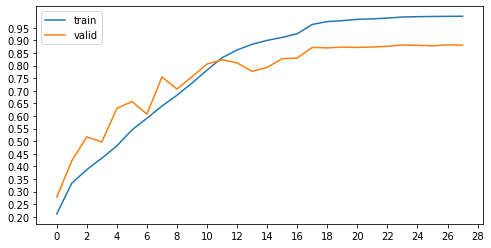

In [17]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

In [19]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 64)        0   

In [20]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True, validation_data=(val_images, val_oh_labels), callbacks=[rlr_cb, ely_cb])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
1329/1329 [==============================] - 14s 10ms/step - loss: 1.5876 - accuracy: 0.4212 - val_loss: 1.3220 - val_accuracy: 0.5435
Epoch 2/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.1490 - accuracy: 0.5934 - val_loss: 1.3053 - val_accuracy: 0.5283
Epoch 3/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.9505 - accuracy: 0.6697 - val_loss: 0.8580 - val_accuracy: 0.7069
Epoch 4/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.8233 - accuracy: 0.7184 - val_loss: 0.8489 - val_accuracy: 0.7221
Epoch 5/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.7148 - accuracy: 0.7578 - val_loss: 0.8899 - val_accuracy: 0.7132
Epoch 6/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.6186 - accuracy: 0.7941 - val_loss: 0.8376 - val_accuracy: 0.7371
Epoch 7/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.5450 - accuracy: 0.8190 - val_loss: 0.6070 -

313/313 [==============================] - 2s 5ms/step - loss: 0.8719 - accuracy: 0.8704


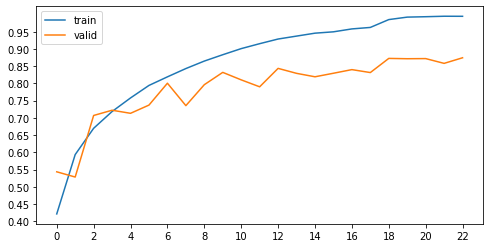

In [21]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

In [23]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
# x = Flatten(name='flatten')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_39 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_39 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_40 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_40 (Activation)   (None, 32, 32, 64)        0   

In [25]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )

Epoch 1/30
1329/1329 [==============================] - 15s 10ms/step - loss: 1.4692 - accuracy: 0.4662 - val_loss: 1.5014 - val_accuracy: 0.4795
Epoch 2/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.0325 - accuracy: 0.6356 - val_loss: 1.2591 - val_accuracy: 0.5821
Epoch 3/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.8437 - accuracy: 0.7066 - val_loss: 0.8986 - val_accuracy: 0.6865
Epoch 4/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.7219 - accuracy: 0.7536 - val_loss: 0.8261 - val_accuracy: 0.7135
Epoch 5/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.6221 - accuracy: 0.7908 - val_loss: 0.7200 - val_accuracy: 0.7508
Epoch 6/30
1329/1329 [==============================] - 14s 10ms/step - loss: 0.5225 - accuracy: 0.8240 - val_loss: 0.7988 - val_accuracy: 0.7435
Epoch 7/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.4554 - accuracy: 0.8483 - val_loss: 0.5731 -

313/313 [==============================] - 1s 4ms/step - loss: 0.7097 - accuracy: 0.8701


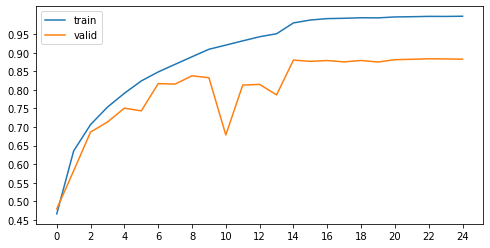

In [26]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2, l1_l2

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가하되 이후 MaxPooling을 적용하지 않고 strides는 2로 변경하여 출력 feature map 크기 조정
x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', kernel_regularizer=l2(1e-5), name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0   

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )

Epoch 1/30
1329/1329 [==============================] - 16s 11ms/step - loss: 1.6866 - accuracy: 0.3995 - val_loss: 1.6210 - val_accuracy: 0.4245
Epoch 2/30
1329/1329 [==============================] - 14s 10ms/step - loss: 1.2443 - accuracy: 0.5731 - val_loss: 1.1974 - val_accuracy: 0.6264
Epoch 3/30
1329/1329 [==============================] - 14s 11ms/step - loss: 1.0644 - accuracy: 0.6522 - val_loss: 1.2420 - val_accuracy: 0.6060
Epoch 4/30
1329/1329 [==============================] - 14s 10ms/step - loss: 0.9654 - accuracy: 0.6951 - val_loss: 0.8798 - val_accuracy: 0.7373
Epoch 5/30
1329/1329 [==============================] - 14s 10ms/step - loss: 0.8828 - accuracy: 0.7359 - val_loss: 0.8683 - val_accuracy: 0.7468
Epoch 6/30
1329/1329 [==============================] - 14s 10ms/step - loss: 0.8050 - accuracy: 0.7768 - val_loss: 1.1921 - val_accuracy: 0.6997
Epoch 7/30
1329/1329 [==============================] - 14s 10ms/step - loss: 0.7434 - accuracy: 0.8068 - val_loss: 0.8146 -

313/313 [==============================] - 1s 5ms/step - loss: 1.0514 - accuracy: 0.8601


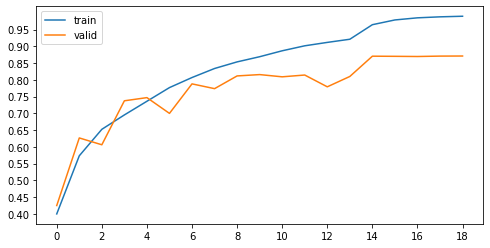

In [15]:
model.evaluate(test_images, test_oh_labels)
show_history(history)